# Preprocessing Cleanup

In [42]:
import pandas as pd
import nltk
import numpy as np
import pickle
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

## Import Datasets

First things first - I will need to read in the datasets for the news and uplifting news post headlines, then combine them into one dataframe. 

In [2]:
df1 = pd.read_csv('../API-data/news_posts_SA')
df1 = df1[:3500]
df1.head()

,Unnamed: 0,compound,headline,neg,neu,pos,news,label
0,0,0.4939,Steve Bannon disinvited from New Yorker festiv...,0.000,0.802,0.198,0,1
1,1,-0.3400,Brazils National Museum Fire What It Means for...,0.231,0.769,0.000,0,-1
2,4,0.4019,Seahawks Owner Gives 100k To Help Republicans ...,0.000,0.816,0.184,0,1
3,7,-0.6486,A 20yearold Instagram star is dead after being...,0.264,0.736,0.000,0,-1
4,8,-0.6124,Dozens Arrested in Marriott Worker Protests in...,0.417,0.583,0.000,0,-1


In [3]:
df2 = pd.read_csv('../API-data/upnews_posts_SA')
df2.head()

,Unnamed: 0,compound,headline,neg,neu,pos,news,label
0,0,-0.5267,10 Nigerian Celebrities Who Have Been Sentence...,0.386,0.614,0.000,1,-1
1,1,0.7003,Philadelphias Homeless Are Finding New Hope Th...,0.000,0.580,0.420,1,1
2,2,0.4588,Kindness can change a life,0.000,0.500,0.500,1,1
3,6,0.2003,Shows Up Culinary Therapy A Different Kind o...,0.057,0.867,0.077,1,1
4,7,0.2382,Up to 50 of the worlds coral has died but scie...,0.083,0.799,0.118,1,1


In [4]:
df = pd.concat((df1, df2), axis=0, ignore_index=True)

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df = df[df.label != 0]
df.label.value_counts()

 1    3556
-1    2888
Name: label, dtype: int64

### Tokenize

Next, I would like to tokenize the headlines to see how large the dataset will be, as well as determine counts.

In [25]:
tokenizer = RegexpTokenizer(r'\w+')
headline_words = [tokenizer.tokenize(title.lower()) for title in titles]
df['tokens'] = headline_words

In [26]:
words = []

for title in headline_words:
    for t in title:
        words.append(t)

In [27]:
unique_words = set(words)

In [10]:
df['length'] = [len(title) for title in df['headline'].values.astype('str')]

In [28]:
len(words), len(unique_words)

(80379, 13803)

There are 80,379 individual words in the headlines, and 13,803 of the words are unique. 

## Count Vectorizer

I will count vectorize the data to explore their frequencies/counts.

In [31]:
cv = CountVectorizer()
cv.fit(words)
word_cv = cv.transform(words)

In [32]:
word_df = pd.DataFrame(word_cv.toarray(), columns=cv.get_feature_names())
word_total = word_df.sum(axis=0)

In [33]:
word_total.sort_values(ascending=False).head(20)

to       2146
the      1814
in       1731
of       1403
and      1122
for      1110
is        622
on        610
with      532
after     451
from      434
by        394
at        369
his       281
new       265
trump     262
this      258
us        257
man       255
as        254
dtype: int64

Unsurprisingly, the most frequently used words are conjunctions and other stop words. This does not tell us much about the data.

I will want to remove stop words from this list, which I can do by re-insantiating Count Vectorizer.

In [35]:
cv_stop = CountVectorizer(stop_words='english')

word_vect_stop = cv_stop.fit_transform(words)

word_df_s = pd.DataFrame(word_vect_stop.toarray(), columns=cv_stop.get_feature_names())
word_total_stop = word_df_s.sum(axis=0)

In [36]:
word_stop_total = word_total_stop.sort_values(ascending=False).head(20)
word_stop_total

new          265
trump        262
man          255
best         243
free         186
news         176
help         163
years        161
worth        157
police       154
people       152
net          148
just         138
biography    124
woman        122
says         116
world        107
online       105
rescue       100
home          97
dtype: int64

This list of words is much more in-line with what I expected - words like "trump", "police", "new" and "man".

Plotting the word frequencies below, we can see the curve at which the words drop off.

<BarContainer object of 20 artists>

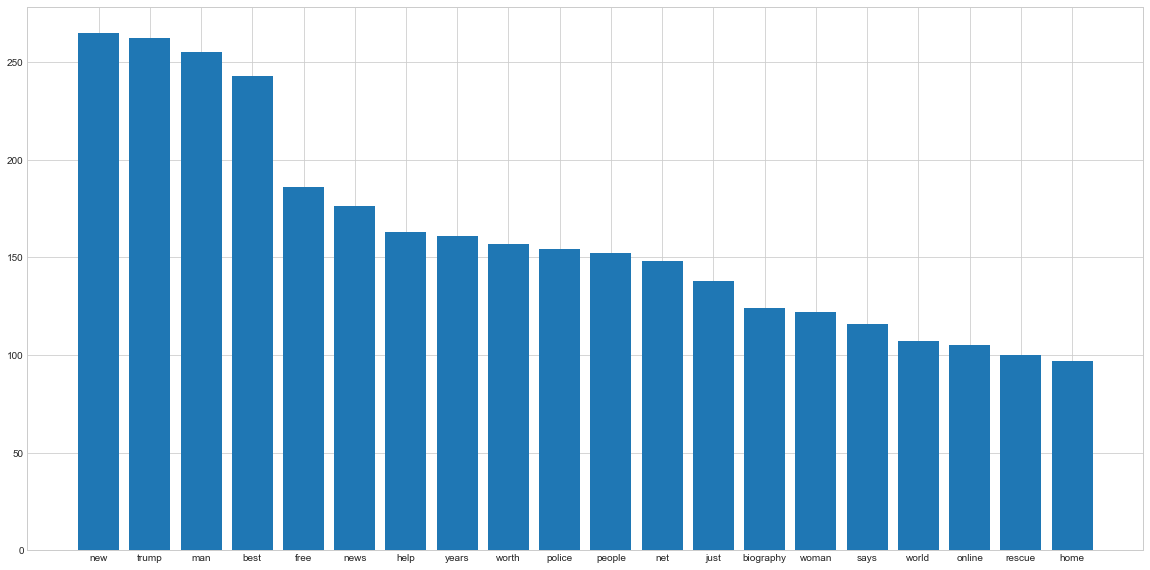

In [54]:
plt.figure(figsize=(20,10))
plt.bar(x = word_stop_total[0:20].index, height = word_stop_total[0:20])

## TF-IDF

I will need to TF-IDF the words in order to prepare them for modeling in the next step. I will likely need to come back to revisit the tf-idf parameters (min_df and max_df) if the model performs badly, as well as consider a higher n-gram.

In [14]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0)
term_mat = tfidf.fit_transform(df['headline'].values.astype('str'))

In [15]:
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())
term_df.fillna(0, inplace=True)

## SVD

In addition, I will have the TF-IDFed terms run through SVD for dimension reduction in order to find the most important features.

In [16]:
SVD = TruncatedSVD(n_components=1000)
svd_matrix = SVD.fit_transform(term_df)
svd_matrix.shape

(6444, 1000)

In [17]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.DataFrame(svd_matrix, columns=component_names)

svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.002344,0.041864,-0.070390,-0.024596,-0.056471,0.126529,-0.118925,-0.007607,-0.011649,-0.024117,...,-0.015365,0.010767,-0.005259,0.016046,-0.002764,-0.003597,0.031479,0.006400,-0.006872,-0.017829
1,0.000149,0.021723,-0.024050,-0.008779,-0.000303,-0.009353,0.009455,0.041358,-0.007122,-0.008816,...,-0.000492,-0.020017,-0.034656,-0.020893,0.020831,-0.022540,-0.028302,0.011068,-0.011464,-0.005344
2,0.001257,0.046476,-0.066259,0.010125,-0.037782,-0.015076,0.013981,0.073273,0.015442,0.225154,...,0.007532,0.030616,0.029705,0.026572,0.042423,-0.014025,-0.027372,-0.004524,0.009520,0.001660
3,0.000335,0.019589,-0.034964,-0.000354,-0.012656,0.013378,0.002825,0.008258,-0.004292,-0.023757,...,0.003082,-0.018339,-0.019945,0.018028,0.041144,0.007007,0.027088,-0.007302,-0.008641,0.031904
4,0.000636,0.021404,-0.036641,0.000196,-0.017781,-0.031659,-0.013466,-0.011424,0.002613,-0.022702,...,-0.002829,0.030377,-0.010239,-0.016661,0.023431,0.016875,-0.014970,0.023899,0.008727,-0.000973


In [18]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.columns).T

In [19]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings.tail()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2
youth,0.000028,0.002982,-0.003584,-0.000567,-0.001254,0.000638,-0.000439,0.006017,-0.000753,-0.002769,...,-0.009370,-0.025803,-0.000417,0.013694,0.000138,-0.025089,-0.001146,-0.016516,0.000028,0.002982
youtube,0.000018,0.003028,-0.003451,-0.001007,-0.001241,0.001163,-0.001641,0.003978,-0.000713,-0.002252,...,0.008211,0.044377,0.014066,-0.000721,0.003330,-0.008613,-0.013463,-0.002459,0.000018,0.003028
zealand,0.000036,0.005342,-0.010574,-0.000278,-0.009027,0.022177,-0.020963,0.001882,-0.002390,-0.005251,...,0.005247,-0.019447,0.028001,0.025001,-0.018343,0.001927,-0.016210,0.007913,0.000036,0.005342
zero,0.000018,0.003051,-0.006030,0.000829,-0.004901,0.000347,0.000542,-0.001457,-0.000601,-0.002008,...,0.001824,-0.015176,0.004380,-0.001260,0.025572,0.077811,0.078961,0.065436,0.000018,0.003051
zoo,0.000013,0.001556,-0.002283,0.000922,-0.001397,-0.002113,0.001286,0.001189,0.000098,-0.000698,...,0.019807,0.003850,-0.007276,0.025102,0.033317,0.021503,0.008202,-0.012123,0.000013,0.001556


In [20]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]


,component_1
biography,0.581280
worth,0.576021
net,0.572655
bio,0.015002
age,0.012610
king,0.012040
neutrality,0.011046
market,0.011024
mercy,0.009943
williams,0.009928


### Target 

I will assign the target variable(s) now - I am making two separate targets, as I would like to test the model for sentiment identification as well as subreddit. 

In [7]:
target_sub = df['news']

target_sent = df['label']

titles = df.headline.values.astype('str')

## Pickle

In [21]:
with open('../Pickle/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../Pickle/term_df.pkl', 'wb') as f:
    pickle.dump(term_df, f)
with open('../Pickle/svd_df.pkl', 'wb') as f:
    pickle.dump(svd_df, f)
with open('../Pickle/target_sub.pkl', 'wb') as f:
    pickle.dump(target_sub, f)
with open('../Pickle/target_sent.pkl', 'wb') as f:
    pickle.dump(target_sent, f)

### Also save dataframe as csv as a backup

In [23]:
df.to_csv('../API-data/headlines')